# Representation
- Multifractal analysis (1ere approche)

- Discrete Fourier Transform (DFT) $\checkmark$
- Spectrogram
- Autoregression $\checkmark$
- Shannon encoding $\checkmark$
- Wavelets (en cours)

- Local symbolic features
- SAX representation
- Approximate entropy

ML

- Autoencoder

- RNN
- LSTM



In [38]:
# !git clone https://github.com/kymatio/kymatio.git
# %pip install -e kymatio

In [39]:
import torch
import torch.nn as nn
import numpy as np
import pywt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log

from sklearn.decomposition import PCA

from scipy.interpolate import interp1d

In [40]:
from pyhrv.hrv import hrv

In [41]:
from kymatio import Scattering1D

In [42]:
# from torch.utils.data import DataLoader, TensorDataset

In [43]:
def reshape_to_batches(array, m):
    """
    Transform an array of shape (n, p) into a list of arrays of shape (m, p).
    """
    array = np.asarray(array)
    p = array.shape[-1]
    num_batches = p // m
    return [array[i * m:(i + 1) * m] for i in range(num_batches)]

In [44]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def fit(self,X):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        n_batch = 32
        # Create a DataLoader for the dataset
        X_tensor = torch.FloatTensor(X)
        dataset = TensorDataset(X_tensor, X_tensor)
        dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
        # Train the autoencoder
        num_epochs = 50
        for epoch in range(num_epochs):
            for data in dataloader:
                inputs, _ = data
                inputs = inputs #.to(device)
                outputs = self(inputs)
                loss = criterion(outputs, inputs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


In [45]:
class IdentityTransform:
    @staticmethod
    def transform(X, **kwargs):
        return X

class Mean:
    @staticmethod
    def transform(X,**kwargs):
        return np.expand_dims(X.mean(axis=-1),axis=-1)
    
class StandardDeviation:
    @staticmethod
    def transform(X,**kwargs):
        return np.expand_dims(X.std(axis=-1),axis=-1)
class FourierTransform:
    @staticmethod
    def transform(X, new_dimension=None, **kwargs):
        """
        Return the fourier transform of size 'new_dimension'.
        """
        fourier_transform = np.fft.fft(X, n=new_dimension,axis=-1)
        modulus = np.abs(fourier_transform)
        return modulus

class LowFourierTransform:
    @staticmethod
    def transform(X, fs=250, cutoff_min=.3, cutoff_max = 4.5, n=None, **kwargs):
        """
        Fourier transform with a cutoff_ratio.

        fs: sampling frequency
        [cutoff_min, cutoff_max]: frequency interval that we consider
        n: new_dimension before cutoff

        Return the cutoff fourier transform.
        """
        fourier_transform = np.fft.fft(X,n=n,axis=-1)
        if n is None:
            n = X.shape[1]
        frequencies = np.fft.fftfreq(n, d=1/fs)
        mask = (cutoff_min < frequencies) & (frequencies < cutoff_max)
        fourier_transform = fourier_transform[:, mask]
        modulus = np.abs(fourier_transform)
        return modulus

class LowPsdTransform:
    @staticmethod
    def transform(X, fs=250, cutoff_min=.3, cutoff_max = 4.5, n=None, **kwargs):
        """
        Power Spectrum Density with a cutoff_ratio.

        fs: sampling frequency
        [cutoff_min, cutoff_max]: frequency interval that we consider
        n: new_dimension before cutoff

        Return the cutoff power spectrum density (the fourier transform of the autocorrelation).
        """
        fourier_transform = np.fft.fft(X, n=n, axis=-1)
        if n is None:
            n = X.shape[1]
        frequencies = np.fft.fftfreq(n, d=1/fs)
        mask = (cutoff_min < frequencies) & (frequencies < cutoff_max)
        fourier_transform = fourier_transform[:, mask]
        psd = fourier_transform * np.conj(fourier_transform)
        return psd.real

class WaveDecTransform:
    @staticmethod
    def transform(X, level=4, wavelet='db1', mode='symmetric', **kwargs):
        """
        Multilevel decomposition
        """
        array = np.array(X)
        coeffs = pywt.wavedec(array, wavelet, mode=mode, level=level)
        coeffs_torch = [torch.tensor(c) for c in coeffs[:1]]
        return torch.cat(coeffs_torch, dim=-1)

class DwtTransform:
    @staticmethod
    def transform(X, wavelet='db1', mode='symmetric', **kwargs):
        """
        Single level decomposition (discrete)
        """
        array = np.array(X)
        coeffs = pywt.dwt(array, wavelet, mode=mode)
        coeffs_torch = [torch.tensor(c) for c in coeffs[:1]]
        return torch.cat(coeffs_torch, dim=-1)
    
class CwtTransform:
    @staticmethod
    def transform(X, scales = np.arange(1,100,20), wavelet='gaus1', pca_components = 10, **kwargs):
        """
        Continuous Wavelet Transform followed by PCA
        """
        array = np.array(X)
        coeffs, freqs = pywt.cwt(array,scales= scales, wavelet=wavelet)
        
        coeffs = np.transpose(coeffs,(1,0,2) )
        
        mean_coefs = np.mean(np.abs(coeffs), axis=1)
        std_coefs = np.std(np.abs(coeffs), axis=1)
        features = np.concatenate((mean_coefs, std_coefs),axis=-1)
        
        pca = PCA(n_components=pca_components) 
        X_pca = pca.fit_transform(features)
        return X_pca
    
class AutoRegTransform:
    @staticmethod
    def get_ar_coefficients(X, k=3, **kwargs):
        """
        Perform an autoregression on each example, the coefficient of the autoregression are used in the representation of the signal.
        
        k: the number of coefficients computed
        """
        n, p = X.shape
        X = np.array(X)
        ar_coefficients = np.zeros((n, k))
        for i in range(n):
            model = AutoReg(X[i], lags=k).fit()
            ar_coefficients[i] = model.params[1:k+1]
        return ar_coefficients

    @staticmethod
    def transform(X, k=3, **kwargs):
        return AutoRegTransform.get_ar_coefficients(X, k)

class ShannonEncodingTransform:
    @staticmethod
    def transform(X, level=4, wavelet='db1', mode='symmetric', **kwargs):
        '''
        Inspired by https://fr.mathworks.com/help/wavelet/ug/ecg-classification-using-wavelet-features.html

        -> ECG Classification Using Wavelet Packet Entropy and Random Forests (https://www.mdpi.com/1099-4300/18/8/285)
        https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Wavelet_packet_entropy_features_python.ipynb
        '''
        def compute_shannon_entropy(signal):
            return -np.nansum(signal**2 * np.log(signal**2))
        
        n_examples = X.shape[0]
        wp = pywt.WaveletPacket(X[0, :], wavelet="sym8", maxlevel=3)
        packet_names = [node.path for node in wp.get_level(3, "natural")]
        
        feature_matrix_wav_packet_entropy = np.full((n_examples, 8), np.nan)
        for i in range(len(X)):
            wp = pywt.WaveletPacket(X[i, :], wavelet="sym8", maxlevel=3)
            for j in range(len(packet_names)):
                new_wp = pywt.WaveletPacket(data=None, wavelet="sym8", maxlevel=3)
                new_wp[packet_names[j]] = wp[packet_names[j]].data
                reconstructed_signal = new_wp.reconstruct(update=False)
                feature_matrix_wav_packet_entropy[i, j] = compute_shannon_entropy(reconstructed_signal)
        return feature_matrix_wav_packet_entropy

class WaveletLeadersTransform:
    @staticmethod
    def transform(X, j1=2, j2=4, **kwargs):
        '''
        Use the multifractal framework.
        The representation obtained is inspired by https://fr.mathworks.com/help/wavelet/ug/ecg-classification-using-wavelet-features.html:
        [ width of the singularity spectrum = degree of multifractality, log_cumulants[1]]
        
        '''
        if X.ndim > 1:
            n = X.shape[0]
        else :
            n = 1
            X = X[None,:]
        transformed_X = -np.ones((n, 2))
        for i in range(X.shape[0]):
            # print(i)
            dwt, lwt = mfa.mf_analysis_full(
                X[i],
                scaling_ranges=[(j1, j2)],
                q=build_q_log(1, 10, 20),
                n_cumul=2,
                p_exp=np.inf,
                gamint=0.0
            )
            sf, cumul, mfs, hmin = lwt
            transformed_X[i, :] = np.max(mfs.hq) - np.min(mfs.hq), cumul.log_cumulants[1].item()
        return transformed_X

class MultiFracsTransform:
    @staticmethod
    def transform(X, j1=2, j2=4, **kwargs):
        '''
        Use the multifractal framework.
        The representation obtained is inspired by HRVMultiScaling_ivanov1999:
        [degree of multifractality, tau(3), X[i].std()]
        where tau(3) is characterizing the scaling of the third moment Z_3(a).
        '''
        if X.ndim > 1:
            n = X.shape[0]
        else :
            n = 1
            X = X[None,:]
        transformed_X = -np.ones((n, 3))
        for i in range(X.shape[0]):
            dwt, lwt = mfa.mf_analysis_full(
                X[i],
                scaling_ranges=[(j1, j2)],
                q=build_q_log(1, 10, 20),
                n_cumul=2,
                p_exp=np.inf,
                gamint=0.0
            )
            sf, cumul, mfs, hmin = lwt
            tau = interp1d(sf.q, sf.zeta[:,0,0], kind='linear')
            degree_of_multifractality = np.max(mfs.hq) - np.min(mfs.hq)
            transformed_X[i, :] = degree_of_multifractality, tau(3).item(), X[i].std()
        return transformed_X
    
class NewMultiFracsTransform:
    @staticmethod
    def transform(X, j1=2, j2=4, **kwargs):
        '''
        Use the multifractal framework.
        The representation obtained is inspired by HRVMultiScaling_ivanov1999:
        [degree of multifractality, tau(3), X[i].std()]
        where tau(3) is characterizing the scaling of the third moment Z_3(a).
        '''
        if X.ndim > 1:
            n = X.shape[0]
        else :
            n = 1
            X = X[None,:]
        transformed_X = -np.ones((n, 5))
        for i in range(X.shape[0]):
            dwt, lwt = mfa.mf_analysis_full(
                X[i],
                scaling_ranges=[(j1, j2)],
                q=build_q_log(1, 10, 20),
                n_cumul=2,
                p_exp=np.inf,
                gamint=0.0
            )
            sf, cumul, mfs, hmin = lwt
            tau = interp1d(sf.q, sf.zeta[:,0,0], kind='linear')
            degree_of_multifractality = np.max(mfs.hq) - np.min(mfs.hq)
            # print(sf.H.item())
            transformed_X[i, :] = degree_of_multifractality, sf.H.item(), tau(2).item(), tau(3).item(), X[i].std()
        return transformed_X

class CrossCorTransform:
    @staticmethod
    def transform(X, new_dim=10, **kwargs):
        """
        Compute the cross covariance between examples and then do PCA.
        """
        crosscor = np.corrcoef(X)

        pca = PCA(n_components=new_dim)
        transformed_data = pca.fit_transform(crosscor)
        return transformed_data# , pca.components_
        
        # eigen_values, eigen_vectors = np.linalg.eigh(crosscor)
        
        # return transformed_X

class AutoCorTransform:
    @staticmethod
    def transform(X, k=4, m=10, **kwargs):
        """
        Weird improvisation, does not work
        """
        
        n = X.shape[0] if X.ndim > 1 else 1
        transformed_X = list()
        for i in range(X.shape[0]):
            batches = reshape_to_batches(X[i],m)
            
            autocor = np.corrcoef(batches)
            # print(autocor.shape)
            pca = PCA(n_components=k)
            transformed_data = pca.fit_transform(autocor)
            transformed_X.append(pca.components_.flatten())
            
        return np.array(transformed_X)
    
class AutoEncoderTransform:
    @staticmethod
    def transform(X, mode = 'n-pretrained', fourier_transform = True, n_fourier = 128, dim_encoder = 16, **kwargs):
        """
        AutoEncoder Transform
        """
        n = 200
        if mode == 'pretrained':
            fX = torch.fft.fft(torch.FloatTensor(X),n = n)
            X = (fX  * torch.conj(fX)).real
            autoencoder = AutoEncoder(n,10)
            autoencoder.load_state_dict(torch.load('autoencoder_state_dict.pth'))
            autoencoder.eval()  # Set the model to evaluation mode
            return autoencoder.encoder(X).detach().numpy()
        
        else:
            if fourier_transform:# PSD  
                fX = torch.fft.fft(torch.FloatTensor(X), n=n_fourier)
                X = (fX  * torch.conj(fX)).real
            X = torch.FloatTensor(X)
            n = X.shape[-1]
            autoencoder = AutoEncoder(n,dim_encoder)
            autoencoder.fit(X)
            autoencoder.eval()  # Set the model to evaluation mode
            return autoencoder.encoder(X).detach().numpy()
    
class WaveletScattering:
    @staticmethod
    def transform(X, J=4, Q=(8,1), pca_components = 0):
        """
        The parameter J specifies the maximum scale of the low-pass filters as a power of two.
        In other words, the largest filter will be concentrated in a time interval of size 2**J

        """
        T = X.shape[-1]
        scattering = Scattering1D(J, T, Q)
        Sx = scattering(X)
        # print('Sx1.shape',Sx.shape)
        n,m, p = Sx.shape
        Sx = Sx.reshape((n,m*p))
        # print('Sx2.shape',Sx.shape)
        if pca_components > 0:
            pca = PCA(n_components=pca_components)
            transformed_data = pca.fit_transform(Sx)
            return transformed_data
        else:
            return Sx
    
class Pointcare:
    @staticmethod
    def transform(X):
        """
        Inspired by https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1c0f83fcc8b58b27ad43bbcc2d5dd41f7e5605ce
        """
        unnormalized_d1 = np.diff(X,axis=-1)
        unnormalized_d2 = unnormalized_d1 + X[...,1:]
        sd1 = np.std(unnormalized_d1 / np.sqrt(2),axis=-1)
        sd2 = np.std(unnormalized_d2 / np.sqrt(2),axis=-1)
        return np.concatenate([np.expand_dims(sd1,-1),np.expand_dims(sd2,-1),np.expand_dims(sd1/sd2,-1)],axis=-1)

class EveryThingPyHRV:
    @staticmethod
    def transform(X,mode='nni', sampling_rate=128):
        """
        https://pyhrv.readthedocs.io/en/latest/index.html
        """
        features = ['sd1','sd2','sd_ratio','dfa_alpha1', 'dfa_alpha2','fft_peak','fft_ratio']
        n = X.shape[0]
        if X.ndim ==1:
            X = X[None,:]
        p = len(features)
        res = np.empty((n,p))
        for i in range(n):
            if mode == 'nni':
                result = hrv(nni=X[i],show=False, sampling_rate=sampling_rate)
            else:
                result = hrv(signal=X[i],show=False, sampling_rate=sampling_rate)
            res[i,:] = [result[feature] for feature in features]
        
        return res

class LexicoEntropy:
    @staticmethod
    def lexico_entropy(nni,D=4,short_treshold=0.7,long_treshold=1.2):
        """
        Calculate the lexical entropy of a Heart Rate Variability (HRV) signal, using a symbolic encoding approach.

        Parameters:
        ----------
        nni : array-like
            The HRV signal, typically an array of successive RR intervals.
        D : int, optional, default=4
            The length of the "words" to be used in the symbolic encoding. 
        short_treshold : float, optional, default=0.7
            The threshold multiplier for short RR intervals, relative to the median of the HRV signal.
        long_treshold : float, optional, default=1.2
            The threshold multiplier for long RR intervals, relative to the median of the HRV signal.

        Returns:
        -------
        float
            The lexical entropy of the encoded HRV signal.

        Description:
        ------------
        1. Computes the median `T` of the HRV signal `nni`.
        2. Encodes each interval in `nni` as:
        - 'L' for long intervals (> `long_threshold * T`)
        - 'S' for short intervals (< `short_threshold * T`)
        - 'N' for neutral intervals (between `short_threshold * T` and `long_threshold * T`)
        3. Generates "words" of length `D` from the encoded sequence.
        4. Calculates the entropy of the distribution of these words.

        This entropy measure provides an indication of the complexity or regularity within the HRV signal.
        """
        T = np.median(nni)
        
        lex_nni = np.empty_like(nni,dtype=str)
        lex_nni.fill('N')
        lex_nni[nni > long_treshold*T] = 'L'
        lex_nni[nni < short_treshold*T] = 'S'
        lex_nni = ''.join(lex_nni)
        l = len(lex_nni)
        
        data = [lex_nni[i:i+D] for i in range(l+1-D)]

        value, counts = np.unique(data,return_counts=True)

        p = counts/ counts.sum()

        return -np.sum(p *np.log2(p)) #  /np.log2(math.factorial(D))

    @staticmethod
    def transform(X,D=4,short_treshold=0.7,long_treshold=1.2):
        res = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            res[i] = LexicoEntropy.lexico_entropy(X[i],D=D,short_treshold=short_treshold,long_treshold=long_treshold)
        return res
    


In [46]:
class TransformationRegistry:
    def __init__(self):
        self.transformations = {}

    def register(self, name, transform_class):
        self.transformations[name] = transform_class

    def get(self, name):
        transform_class = self.transformations.get(name)
        if transform_class is None:
            raise ValueError(f"Transformation {name} not recognized.")
        return transform_class


In [47]:
class DataTransform:
    def __init__(self, registry, save_data = True,verbose = True):
        self.registry = registry

        self.save_data = save_data
        self.data = {}

    @staticmethod
    def handle_trans_kwargs(input):
        '''
        input: [str, dict] or [str] or str
        Return: str, dict or str, {}
        '''
        if isinstance(input, list):
            if len(input) == 2 and isinstance(input[0], str) and isinstance(input[1], dict):
                return input[0], input[1]
            elif len(input) == 1 and isinstance(input[0], str):
                return input[0], {}
            else:
                raise ValueError("Invalid list input. Expected [str, dict] or [str].")
        elif isinstance(input, str):
            return input, {}
        else:
            raise ValueError("Invalid input type. Expected [str, dict], [str], or str.")
        
    @staticmethod
    def get_trans_kwargs_str(trans_name, kwargs):
        def str_dict(dictionnary):
            res = ''
            for key,value in dictionnary.items():
                res+=f'{key}={value}_'
            return res
        return (trans_name + '_' + str_dict(kwargs) )[:-1]
    
    @staticmethod
    def get_full_trans_kwargs_str(transformation):
        # print(transformation)
        res =''
        transformation = DataTransform.sanitize_transformations(transformation)
        for trans in transformation:
            res += DataTransform.get_trans_kwargs_str(*DataTransform.handle_trans_kwargs(trans))+'_'
        
        return res[:-1]
    
    @staticmethod
    def sanitize_transformations(transformations):
        if isinstance(transformations, str):
            sanitized_transformations = [[transformations]]
        elif isinstance(transformations, list) and len(transformations) == 2 and isinstance(transformations[0], str) and isinstance(transformations[1], dict):
            sanitized_transformations = [transformations]

        elif isinstance(transformations, list):
            sanitized_transformations = []
            for item in transformations:
                if isinstance(item, str):
                    sanitized_transformations.append([item])
                elif isinstance(item, list) and len(item) == 2 and isinstance(item[0], str) and isinstance(item[1], dict):
                    sanitized_transformations.append(item)
                elif isinstance(item, list) and len(item) == 1 and isinstance(item[0], str):
                    sanitized_transformations.append(item)
                else:
                    raise ValueError("Invalid list input. Expected [str, dict] or [str].")
        return sanitized_transformations
    
    def apply_transformation(self, X, transformations):      #, **kwargs):
        '''
        X: data
        transformations: [str, [str, dict], [str], ...] or [str] or str
        '''
        
        sanitized_transformations = DataTransform.sanitize_transformations(transformations)
        transformed_parts = []
        if X.ndim > 1:
            n = X.shape[0]
        else :
            n = 1
            X = X[None,:]
            
        for transformation in sanitized_transformations:
            trans_name, kwargs = DataTransform.handle_trans_kwargs(transformation)
            trans_name_kwargs = DataTransform.get_trans_kwargs_str(trans_name, kwargs)

            if self.save_data and (trans_name_kwargs in self.data.keys()):
                transformed_parts.append(self.data[trans_name_kwargs])
            else:
                transform_class = self.registry.get(trans_name)
                print(f'Computing  {trans_name_kwargs} ...', end='', flush=True)
                transformed_part = transform_class.transform(X, **kwargs)
                print('\r' + ' ' * len(f'Computing  {trans_name} ...') + '\r', end='')
                self.data[trans_name_kwargs] = transformed_part
                transformed_parts.append(transformed_part)

        return np.concatenate(transformed_parts, axis=1)


In [48]:
def initialize_registry():
    registry = TransformationRegistry()

    # Register transformations
    registry.register('identity', IdentityTransform)
    registry.register('mean', Mean)
    registry.register('std', StandardDeviation)
    registry.register('fourier', FourierTransform)
    registry.register('low_fourier', LowFourierTransform)
    registry.register('low_psd', LowPsdTransform)
    registry.register('wavedec', WaveDecTransform)
    registry.register('dwt', DwtTransform)
    registry.register('cwt', CwtTransform)
    registry.register('autoreg', AutoRegTransform)
    registry.register('shannon_encoding', ShannonEncodingTransform)
    registry.register('wavelet_leaders', WaveletLeadersTransform)
    registry.register('multifracs', MultiFracsTransform)
    registry.register('newmultifracs', NewMultiFracsTransform)
    registry.register('crosscor', CrossCorTransform)
    registry.register('autocor', AutoCorTransform)
    registry.register('autoencoder', AutoEncoderTransform)
    registry.register('waveletscattering', WaveletScattering)
    registry.register('pointcare', Pointcare)
    registry.register('pyhrv', EveryThingPyHRV)
    registry.register('lexico',LexicoEntropy)
    return registry

In [49]:
if __name__ == "__main__":
    # Initialize the registry
    registry = initialize_registry()

Transformation: identity, Shape: (100, 150)
Transformation: mean, Shape: (100, 1)
Transformation: std, Shape: (100, 1)
Transformation: fourier, Shape: (100, 150)
Transformation: low_fourier, Shape: (100, 2)
Transformation: low_psd, Shape: (100, 2)
Transformation: wavedec, Shape: (100, 10)
Transformation: dwt, Shape: (100, 75)
Transformation: cwt, Shape: (100, 10)
Transformation: autoreg, Shape: (100, 3)
Transformation: shannon_encoding, Shape: (100, 8)
Transformation: wavelet_leaders, Shape: (100, 2)
Transformation: multifracs, Shape: (100, 3)
Transformation: newmultifracs, Shape: (100, 5)
Transformation: crosscor, Shape: (100, 10)
Transformation: autocor, Shape: (100, 60)
Transformation: autoencoder, Shape: (100, 16)
Transformation: waveletscattering, Shape: (100, 450)
Transformation: pointcare, Shape: (100, 3)
Computing  pyhrv ...

c:\Users\aejog\anaconda3\Lib\site-packages\pyhrv\utils.py:367: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
c:\Users\aejog\anaconda3\Lib\site-packages\pyhrv\time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")
c:\Users\aejog\anaconda3\Lib\site-packages\pyhrv\time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


ValueError: Expect x to not have duplicates

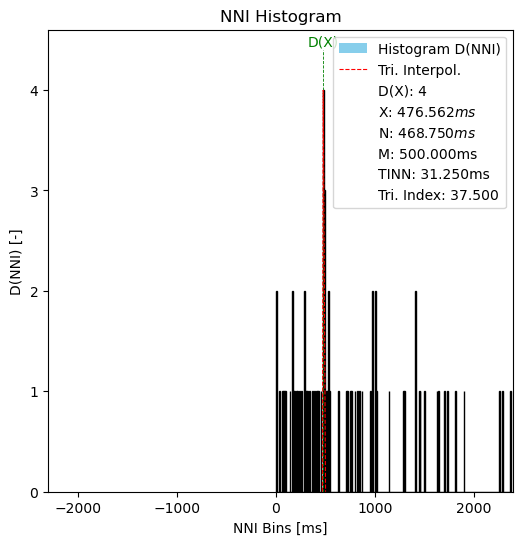

In [51]:
if __name__ == "__main__":
    # Initialize the data transformer
    data_transformer = DataTransform(registry)

    # Example input data
    X = np.random.randn(100, 150)  # Example input data
    y = np.random.randint(0, 2, 100)  # Example labels
    
    for trans_names in registry.transformations.keys():
        trans_names_str = [str(name) for name in trans_names]
        trans_name_str = '+'.join(trans_names_str) if isinstance(trans_names, list) else trans_names
        kwargs = trans_names[1] if isinstance(trans_names, list) and len(trans_names) > 1 else {}
        trans_names = trans_names[0] if isinstance(trans_names, list) else trans_names
        
        # Apply transformation
        transformed_X = data_transformer.apply_transformation(X, trans_names, **kwargs)
        
        print(f"Transformation: {trans_name_str}, Shape: {transformed_X.shape}")
        

In [ ]:
if __name__ == "__main__":
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    from sklearn.preprocessing import StandardScaler

    

    # Define the classifiers to be tested
    classifiers = {
        'SVM': SVC(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier()
    }

    # Define the transformations to be tested
    transformations = [
        'identity',
        ['crosscor'],
        ['autocor',{'m':4,'k':4}],
        [['fourier'],['crosscor']],
        ['wavedec'],
        ['autoreg', {'k': 3}]
    ]

    

    # Function to evaluate a classifier using cross-validation
    def evaluate_classifier_cv(classifier, X, y):
        scores = cross_val_score(classifier, X, y, cv=5)  # 5-fold cross-validation
        return np.mean(scores), np.std(scores)

    # Loop over each transformation and each classifier
    results = {}

    for trans in transformations:

        trans_name_str = DataTransform.get_full_trans_kwargs_str(trans)
        # trans_name_str = '+'.join(trans_names_str) if isinstance(trans_names, list) else trans_names
        # kwargs = trans_names[1] if isinstance(trans_names, list) and len(trans_names) > 1 else {}
        # trans_names = trans_names[0] if isinstance(trans_names, list) else trans_names
        
        # Apply transformation
        # print(trans)
        transformed_X = data_transformer.apply_transformation(X, trans)
        # Standardize the data (important for some classifiers like SVM)
        scaler = StandardScaler()
        transformed_X = scaler.fit_transform(transformed_X)
        
        results[trans_name_str] = {}
        for clf_name, clf in classifiers.items():
            # Evaluate the classifier with cross-validation
            mean_accuracy, std_accuracy = evaluate_classifier_cv(clf, transformed_X, y)
            results[trans_name_str][clf_name] = (mean_accuracy, std_accuracy)
            print(f"Transformation: {trans_name_str}, Classifier: {clf_name}, Mean Accuracy: {mean_accuracy:.3f}, Std Dev: {std_accuracy:.3f}")

    # Print the results
    for trans_name, clf_results in results.items():
        for clf_name, (mean_accuracy, std_accuracy) in clf_results.items():
            print(f"Transformation: {trans_name}, Classifier: {clf_name}, Mean Accuracy: {mean_accuracy:.3f}, Std Dev: {std_accuracy:.3f}")


Transformation: identity, Classifier: SVM, Mean Accuracy: 0.540, Std Dev: 0.066
Transformation: identity, Classifier: DecisionTree, Mean Accuracy: 0.530, Std Dev: 0.081
Transformation: identity, Classifier: RandomForest, Mean Accuracy: 0.540, Std Dev: 0.080
Transformation: crosscor, Classifier: SVM, Mean Accuracy: 0.470, Std Dev: 0.121
Transformation: crosscor, Classifier: DecisionTree, Mean Accuracy: 0.540, Std Dev: 0.146
Transformation: crosscor, Classifier: RandomForest, Mean Accuracy: 0.390, Std Dev: 0.092
Transformation: autocor_m=4_k=4, Classifier: SVM, Mean Accuracy: 0.530, Std Dev: 0.144
Transformation: autocor_m=4_k=4, Classifier: DecisionTree, Mean Accuracy: 0.520, Std Dev: 0.093
Transformation: autocor_m=4_k=4, Classifier: RandomForest, Mean Accuracy: 0.550, Std Dev: 0.071
Transformation: fourier_crosscor, Classifier: SVM, Mean Accuracy: 0.460, Std Dev: 0.086
Transformation: fourier_crosscor, Classifier: DecisionTree, Mean Accuracy: 0.460, Std Dev: 0.097
Transformation: four

KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    # Initialize the data transformer
    data_transformer = DataTransform(registry)

    # Example input data
    data = np.load('ecgs_labels.npy')
    X, y = data[:,:-1], data[:,-1] # Example input data
    p = np.random.permutation(X.shape[0])
    X = X[p,:]
    y =y[p]
    for i in range(X.shape[0]):
        # Apply transformation
        print(i)
        transformed_X = data_transformer.apply_transformation(X[i,:][None,:], ['multifracs',{'i':i}])


FileNotFoundError: [Errno 2] No such file or directory: 'ecgs_labels.npy'